In [4]:
import pandas as pd
import numpy as np
import gensim
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [5]:
train_orders = pd.read_csv("./data/instacart_2017_05_01/order_products__train.csv")
prior_orders = pd.read_csv("./data/instacart_2017_05_01/order_products__prior.csv")
products = pd.read_csv("./data/instacart_2017_05_01/products.csv").set_index('product_id')

In [7]:
train_orders.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [8]:
prior_orders.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [9]:
products.head()

product_name  aisle_id  \
product_id                                                                
1                                  Chocolate Sandwich Cookies        61   
2                                            All-Seasons Salt       104   
3                        Robust Golden Unsweetened Oolong Tea        94   
4           Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
5                                   Green Chile Anytime Sauce         5   

            department_id  
product_id                 
1                      19  
2                      13  
3                       7  
4                       1  
5                      13

In [10]:
orders = pd.read_csv("./data/instacart_2017_05_01/orders.csv")

In [11]:
orders.shape

(3421083, 7)

In [12]:
orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [13]:
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

In [19]:
train_orders.dtypes

order_id              int64
product_id           object
add_to_cart_order     int64
reordered             int64
dtype: object

In [21]:
train_products = train_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())

In [22]:
sentences = prior_products.append(train_products)
longest = np.max(sentences.apply(len))
sentences = sentences.values

In [23]:
sentences

array([list(['33120', '28985', '9327', '45918', '30035', '17794', '40141', '1819', '43668']),
       list(['33754', '24838', '17704', '21903', '17668', '46667', '17461', '32665']),
       list(['46842', '26434', '39758', '27761', '10054', '21351', '22598', '34862', '40285', '17616', '25146', '32645', '41276']),
       ...,
       list(['15629', '4347', '34466', '6244', '6858', '30316', '35578', '32650']),
       list(['49235', '13565', '14233', '35548']),
       list(['35951', '16953', '4724'])], dtype=object)

In [136]:
# model = gensim.models.Word2Vec(sentences, size=100, window=longest, min_count=2, workers=4)
model = gensim.models.Word2Vec(sentences, size=200, window=longest, min_count=2, workers=10)

In [137]:
for k, v in model.wv.vocab.items():
    print(k, v)
    break

33120 Vocab(count:20234, index:199, sample_int:4294967296)


In [34]:
vocab = list(model.wv.vocab.keys())

In [36]:
pca = PCA(n_components=2)
pca.fit(model.wv.vectors)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [37]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/sanchitrk/Workspace/myspace/jupyter-musings/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
/Users/sanchitrk/Workspace/myspace/jupyter-musings/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


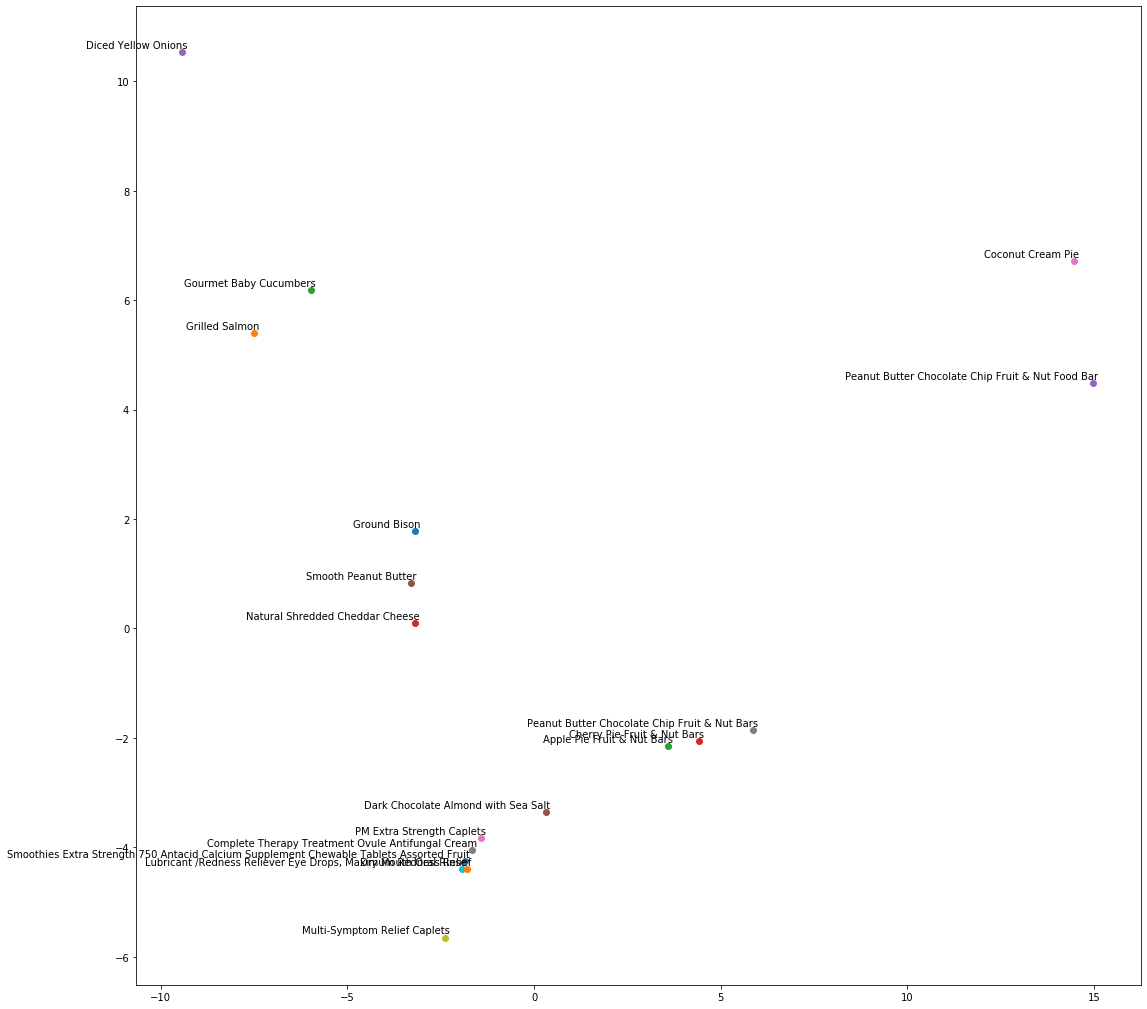

In [38]:
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=3):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)
embeds = pca.fit_transform(embeds)
plot_with_labels(embeds, labels)

In [39]:
model.wv.most_similar('33120')

[('49075', 0.7397878170013428),
 ('11090', 0.7078572511672974),
 ('28289', 0.7044261693954468),
 ('5646', 0.7014751434326172),
 ('10017', 0.6756219863891602),
 ('17878', 0.6741734743118286),
 ('41328', 0.6468459367752075),
 ('4799', 0.641588568687439),
 ('5212', 0.6329424381256104),
 ('41149', 0.631759524345398)]

In [138]:
p1 = ['25447']
model.wv.most_similar(positive=p1)

[('3827', 0.7380211353302002),
 ('37997', 0.6611252427101135),
 ('3085', 0.563064694404602),
 ('23579', 0.5436767935752869),
 ('29163', 0.5354325175285339),
 ('48834', 0.534522294998169),
 ('4376', 0.5345034003257751),
 ('5771', 0.531256377696991),
 ('10933', 0.5214654207229614),
 ('44532', 0.5180461406707764)]

In [40]:
model.wv.most_similar('49075')

[('33120', 0.7397879362106323),
 ('28289', 0.7150018215179443),
 ('4799', 0.7124913334846497),
 ('21543', 0.7054896354675293),
 ('3376', 0.6974142789840698),
 ('33731', 0.6973244547843933),
 ('39121', 0.689216136932373),
 ('39024', 0.6887022256851196),
 ('14678', 0.6863542795181274),
 ('14462', 0.6820942163467407)]

In [45]:
products.head()

product_name  aisle_id  \
product_id                                                                
1                                  Chocolate Sandwich Cookies        61   
2                                            All-Seasons Salt       104   
3                        Robust Golden Unsweetened Oolong Tea        94   
4           Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
5                                   Green Chile Anytime Sauce         5   

            department_id  
product_id                 
1                      19  
2                      13  
3                       7  
4                       1  
5                      13

In [83]:
products[products['product_name']=='Peanut Butter Chocolate Chip Fruit & Nut Bars']

product_id                                   product_name  aisle_id  \
25446       25447  Peanut Butter Chocolate Chip Fruit & Nut Bars         3   

       department_id  
25446             19

In [69]:
products[products['product_name']=='PM Extra Strength Caplets']

product_id               product_name  aisle_id  department_id
3746        3747  PM Extra Strength Caplets       133             11

In [50]:
model.wv.most_similar('11555')

[('29755', 0.6857825517654419),
 ('10724', 0.625838577747345),
 ('7753', 0.622451901435852),
 ('23079', 0.6065945029258728),
 ('17997', 0.597887396812439),
 ('25447', 0.59781813621521),
 ('7563', 0.5842103958129883),
 ('29836', 0.578782320022583),
 ('34991', 0.5659524202346802),
 ('39774', 0.557694673538208)]

In [56]:
p1=['29755', '11555']
model.wv.most_similar(negative=p1)

[('6677', 0.5182899236679077),
 ('9151', 0.4636049270629883),
 ('34229', 0.4482875466346741),
 ('12126', 0.4393928647041321),
 ('9738', 0.43814367055892944),
 ('10280', 0.4362514019012451),
 ('35266', 0.4348735213279724),
 ('14572', 0.4247726798057556),
 ('27763', 0.42393776774406433),
 ('49189', 0.4215927720069885)]

In [57]:
model.wv.most_similar(positive=p1)

[('7563', 0.6650089025497437),
 ('10724', 0.6617945432662964),
 ('17997', 0.6460184454917908),
 ('42093', 0.641670823097229),
 ('29836', 0.6335696578025818),
 ('13592', 0.6247516870498657),
 ('23079', 0.6246660947799683),
 ('8607', 0.6246203184127808),
 ('1823', 0.6192206740379333),
 ('19752', 0.6142579317092896)]

In [60]:
original_products = pd.read_csv("./data/instacart_2017_05_01/products.csv")

In [63]:
original_products[original_products['product_id'] == 11555]

product_id                         product_name  aisle_id  \
11554       11555  Dark Chocolate Almond with Sea Salt        45   

       department_id  
11554             19

In [80]:
prior_orders[prior_orders['product_id'] == '49302'].head()

order_id product_id  add_to_cart_order  reordered
368539      38841      49302                  5          1
433463      45900      49302                 19          0
722890      76491      49302                  2          1
739084      78201      49302                  5          1
1354341    142824      49302                  8          0

In [84]:
"""
exploring similar products
get products similar to each other
"""
p1 = ['25447']
model.wv.most_similar(positive=p1)

[('3827', 0.7962327003479004),
 ('37997', 0.7086731791496277),
 ('23579', 0.610619306564331),
 ('11555', 0.59781813621521),
 ('22227', 0.595726728439331),
 ('4376', 0.5898410081863403),
 ('29163', 0.5716349482536316),
 ('10933', 0.5715937614440918),
 ('3085', 0.5692175626754761),
 ('44532', 0.564217209815979)]

In [82]:
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [140]:
from collections import defaultdict
counter = defaultdict(int)
def validate(df):
    outer_loop = 0
    inner_loop = 0
    for row in df[df['product_id'] == '25447'].iterrows():
        outer_loop += 1
        order_having_product_id = row[1].order_id
        for row2 in df[df['order_id'] == order_having_product_id].iterrows():
            inner_loop += 1
            counter[row2[1].product_id] += 1
    print(f"outer loop:{outer_loop}")
    print(f"inner loop:{inner_loop}")

In [141]:
validate(prior_orders)
validate(train_orders)

outer loop:456
inner loop:6718
outer loop:26
inner loop:467


In [142]:
count = 0
for k, v in sorted(counter.items(), key=lambda kv: kv[1], reverse=True):
    print(k, v)
    if count == 50:
        break
    count += 1

25447 482
24852 91
13176 73
21903 50
44632 47
47766 39
47626 34
47209 32
21137 29
42265 27
27845 26
4920 26
22035 26
49235 25
35221 24
27966 22
49683 22
22935 22
45066 21
37646 21
40706 21
14947 21
30489 21
28199 20
33716 20
16797 19
26209 19
24964 19
25890 19
27086 18
21709 18
8518 18
46979 18
21616 17
45007 17
28465 17
19057 17
20119 16
10749 16
24799 16
3827 16
8277 16
28985 15
5450 15
48679 15
44359 14
21938 14
47144 14
37997 14
5876 14
39877 14


In [139]:
count = 0
p1 = ['25447']
negative_sample = [k[0] for k in model.wv.most_similar(negative=p1, topn=10)]
positive_sample = [k[0] for k in model.wv.most_similar(positive=p1, topn=10)]
for k, v in sorted(counter.items(), key=lambda kv: kv[1], reverse=True):
    if k in positive_sample:
        print(f"found positive & Count: {k}: {v}")
    if k in negative_sample:
        print(f"found negative & Count: {k}: {v}")

found positive & Count: 3827: 16
found positive & Count: 37997: 14
found positive & Count: 23579: 11
found positive & Count: 4376: 7
found positive & Count: 48834: 4
found positive & Count: 44532: 4
found positive & Count: 29163: 1


In [104]:
for row in train_orders[train_orders['product_id']=='25447'].iterrows():
    print(row[1])
    break

order_id             98463
product_id           25447
add_to_cart_order        5
reordered                0
Name: 39988, dtype: object


In [102]:
train_orders[train_orders['order_id']==98463]

order_id product_id  add_to_cart_order  reordered
39984     98463       3849                  1          1
39985     98463      44632                  2          1
39986     98463      28289                  3          0
39987     98463      30489                  4          1
39988     98463      25447                  5          0
39989     98463       8424                  6          0
39990     98463      12206                  7          1
39991     98463      23919                  8          1

In [129]:
p1 = ['25447']
model.wv.most_similar(negative=p1)

[('34103', 0.47494831681251526),
 ('23574', 0.45871588587760925),
 ('48101', 0.45731282234191895),
 ('20698', 0.4563813805580139),
 ('44939', 0.44554585218429565),
 ('30870', 0.4432227611541748),
 ('49189', 0.43786725401878357),
 ('35970', 0.43757814168930054),
 ('14613', 0.4361680746078491),
 ('36112', 0.4352860748767853)]